QUANTITATIVE TRAIT LOCI are regions of the genome associated with traits such as height, BMI etc.. If the trait is an expression of a gene then we are faced with an eQTL. 

# Imports and Consts

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_PAH = "./Dataset/"
CHOSEN_CHROMOSOME = 19

# Load and preprocess data

In [3]:
rnaSeqData = pd.read_csv(DATASET_PAH + "GD660.GeneQuantRPKM.txt", delimiter="\t")

In [4]:
rnaSeqData

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.94950,0.95837,0.51002,0.29422,0.22960,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53929,ENSG00000172297.6,ENSG00000172297.6,Y,27600708,0.13907,0.10224,0.00000,0.08924,0.19945,0.00000,...,0.07151,0.00000,0.18889,0.08700,0.15464,0.13199,0.19273,0.15151,0.11010,0.15483
53930,ENSG00000259738.1,ENSG00000259738.1,15,59157205,0.00000,0.13191,0.00000,0.00000,0.15789,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53931,ENSG00000212040.1,ENSG00000212040.1,14,101498324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53932,ENSG00000125266.5,ENSG00000125266.5,13,107187462,0.12923,0.07601,0.32377,0.25588,0.05295,0.16194,...,0.34558,0.12560,0.22624,0.08303,0.15089,0.09111,0.13432,0.19148,0.05730,0.12557


In [5]:
f = open(DATASET_PAH + "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf", "r")
columns = None
for l in f:
    if "#CHROM" in l:
        columns = l.split("\t")
        break

In [6]:
columns[0] = columns[0].replace("#", "")

In [7]:
columns[len(columns) - 1] = columns[len(columns) - 1].replace("\n", "")

In [8]:
vcfSourceFile = pd.read_csv(
    DATASET_PAH + "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf",
    sep="\t",
    comment="#",
    names=columns,
    header=None,
)

/tmp/ipykernel_90097/2618528307.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcfSourceFile = pd.read_csv(


In [9]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,1,645710,ALU_umary_ALU_2,A,<INS:ME:ALU>,.,.,AC=35;AF=0.00698882;AFR_AF=0;AMR_AF=0.0072;AN=...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,1,668630,DUP_delly_DUP20532,G,<CN2>,.,PASS,AC=64;AF=0.0127795;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,1,713044,DUP_gs_CNV_1_713044_755966,C,"<CN0>,<CN2>",.,PASS,"AC=3,206;AF=0.00059904,0.0411342;AFR_AF=0,0.03...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,2|0,0|0,2|0,0|2
3,1,738570,UW_VH_21763,G,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,1,766600,UW_VH_5595,G,<CN0>,100,PASS,AC=188;AF=0.0375399;AFR_AF=0.0151;AMR_AF=0.062...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68813,X,155064470,DUP_gs.X_CNV_X_155064470_155081667,C,<CN2>,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
68814,X,155090084,UW_VH_7995,A,<CN0>,100,PASS,AC=102;AF=0.0385383;AFR_AF=0.1369;AMR_AF=0.015...,GT,.,...,.,.,.,.,.,0|0,0|0,0|0,0|0,0|0
68815,X,155120139,L1_umary_LINE1_3151,T,<INS:ME:LINE1>,.,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
68816,X,155122541,DEL_pindel_54975,GAGTAACTGGGATGACAGGCGTGTGCCACCACGCCTGGCTAATTTT...,G,.,PASS,AC=1;AF=0.00019968;AFR_AF=0.0008;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [10]:
def processChr(row):
    if row["Chr"] not in ["X", "Y", "M"]:
        row["Chr"] = str(row["Chr"])
    return row


rnaSeqData = rnaSeqData.apply(lambda x: processChr(x), axis=1)

In [11]:
rnaSeqData["Chr"].unique()

array(['11', '6', '15', '16', 'Y', '4', '1', '7', '10', '22', '20', '14',
       '2', '8', '9', '12', '19', '17', '21', '5', '13', '3', 'X', '18',
       'M'], dtype=object)

In [12]:
def processCHROM(row):
    if row["CHROM"] not in ["X", "Y", "M"]:
        row["CHROM"] = str(row["CHROM"])
    return row


vcfSourceFile = vcfSourceFile.apply(lambda x: processCHROM(x), axis=1)

vcfSourceFile["CHROM"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'],
      dtype=object)

In [13]:
vcfSourceFile.groupby(by="CHROM").size()

CHROM
1     4671
10    3126
11    3375
12    3299
13    2485
14    2097
15    1867
16    2062
17    1926
18    2005
19    1621
2     5642
20    1569
21     877
22     848
3     4811
4     4780
5     4425
6     4187
7     4200
8     3681
9     3001
X     2263
dtype: int64

In [14]:
rnaSeqData.groupby(by="Chr").size()

Chr
1     5172
10    2199
11    3121
12    2747
13    1185
14    2182
15    2021
16    2292
17    2207
18     562
19    1939
2     3872
20    1276
21     694
22    1187
3     2917
4     2494
5     2734
6     2794
7     2770
8     2315
9     2334
M       37
X     2328
Y      555
dtype: int64

In [15]:
vcfSourceFile.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096',
       ...
       'NA21128', 'NA21129', 'NA21130', 'NA21133', 'NA21135', 'NA21137',
       'NA21141', 'NA21142', 'NA21143', 'NA21144'],
      dtype='object', length=2513)

In [16]:
vcfSourceFile["CHROM"] = vcfSourceFile["CHROM"].apply(lambda x: str(x))
# I pick only 1 chromosome to make sure the computation time is reasonable
vcfSourceFile = vcfSourceFile[vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)].copy()

In [17]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
61640,19,251548,DUP_gs_CNV_19_251548_283564,C,<CN2>,.,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61641,19,266428,DUP_uwash_chr19_266428_341459,T,<CN2>,.,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61642,19,286841,DUP_gs_CNV_19_286841_307454,T,"<CN0>,<CN2>",.,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61643,19,293937,BI_GS_DEL1_B2_P2673_28,G,<CN0>,100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61644,19,323368,DUP_gs_CNV_19_323368_334484,A,"<CN0>,<CN2>",.,PASS,"AC=1,8;AF=0.00019968,0.00159744;AFR_AF=0,0.002...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63256,19,58999008,SVA_umary_SVA_769,T,<INS:ME:SVA>,.,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63257,19,59015810,BI_GS_DEL1_B2_P2732_9,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63258,19,59020256,UW_VH_3019,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63259,19,59021221,BI_GS_DEL1_B5_P2732_16,T,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [18]:
newColumns = []
for i in range(len(rnaSeqData.columns)):
    newColumns.append(rnaSeqData.columns[i].split(".")[0])

In [19]:
rnaSeqData.columns = newColumns

In [20]:
rnaSeqData = rnaSeqData[rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)].copy()

In [21]:
commonColumns = rnaSeqData.columns.intersection(vcfSourceFile.columns)

In [22]:
commonColumns

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00108',
       ...
       'NA20809', 'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814',
       'NA20815', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=445)

In [23]:
# Data preprocessing: ensuring proper types, mapping

vcfSourceFile["QUAL"] = vcfSourceFile["QUAL"].apply(lambda x: int(x) if x != "." else 0)

for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(
        # lambda x: sum([int(n) for n in x.split("|")]) if x != "." else 0
        lambda x: max([int(n) for n in x.split("|")]) if x != "." else 0
    )
for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(lambda x: int(x))

vcfSourceFile["ALT"] = vcfSourceFile["ALT"].apply(lambda x: x.split(","))


def processRow(row):
    for column in commonColumns:
        if row[column] != 0:
            row[column] = row["ALT"][row[column] - 1]
    return row


vcfSourceFile = vcfSourceFile.apply(lambda x: processRow(x), axis=1)

# 1. DONE: For each row count the number of occurences of each ALT, save it to a dictionary and turn to a dataframe, and merge based on id with vcf data
# 2. Find a way to merge rna and vcf dataframes, perhaps on closest position

In [24]:
def countUniqueALTs(row, d):
    uniqueALTs = row[commonColumns].unique()
    rowId = row.name
    d[rowId] = {}
    for alt in uniqueALTs:
        if alt == 0:
            continue
        d[rowId][alt] = 0
        for column in commonColumns:
            if row[column] == alt:
                d[rowId][alt] = d[rowId][alt] + 1
    for alt in d[rowId]:
        row[alt] = d[rowId][alt]
    return row


d = {}
vcfSourceFileCountedAlts = vcfSourceFile.apply(lambda x: countUniqueALTs(x, d), axis=1)

In [25]:
vcfSourceFileCountedAlts["POS"]

61640      251548
61641      266428
61642      286841
61643      293937
61644      323368
           ...   
63256    58999008
63257    59015810
63258    59020256
63259    59021221
63260    59035015
Name: POS, Length: 1621, dtype: int64

In [26]:
rnaSeqData.columns

Index(['TargetID', 'Gene_Symbol', 'Chr', 'Coord', 'HG00096', 'HG00097',
       'HG00099', 'HG00099', 'HG00100', 'HG00101',
       ...
       'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814', 'NA20815',
       'NA20816', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=664)

In [27]:
rnaSeqData["Coord"]

33       58581338
51       32417479
86       50706885
140      55583407
193      45681485
           ...   
53781    19384074
53798    40079595
53806    17666460
53807    58790318
53863    52196593
Name: Coord, Length: 1939, dtype: int64

In [28]:
rnaSeqData = rnaSeqData.reset_index()

In [29]:
vcfSourceFileCountedAlts = vcfSourceFileCountedAlts.reset_index()

In [30]:
def findClosestRna(rnaRow, closestRna, vcfRow):
    distance = np.abs(vcfRow["POS"] - rnaRow["Coord"])
    if distance < closestRna["distance"]:
        closestRna["closest"] = rnaRow.name
        closestRna["distance"] = distance


def mergeRnaOnClosest(row, rna):
    closestRna = {"closest": -1, "distance": np.inf}
    rna.apply(lambda x: findClosestRna(x, closestRna, row), axis=1)
    # Merge on closestRna
    # print(closestRna["closest"])
    return pd.concat([row, rna.iloc[closestRna["closest"]]], axis=0)


rnaSeqData["mean"] = rnaSeqData[commonColumns].mean(axis=1)
vcfRnaMerged = vcfSourceFileCountedAlts.apply(
    lambda x: mergeRnaOnClosest(x, rnaSeqData), axis=1
).reset_index()

In [31]:
vcfRnaMerged

,level_0,index,<CN0>,<CN2>,<CN3>,<INS:ME:ALU>,<INS:ME:LINE1>,<INS:ME:SVA>,<INS:MT>,<INV>,...,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828,mean
0,0,61640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
1,1,61641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.22144,0.00000,0.02241,0.02446,0.02463,0.12592,0.18296,0.02877,0.13952,0.123668
2,2,61642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.22144,0.00000,0.02241,0.02446,0.02463,0.12592,0.18296,0.02877,0.13952,0.123668
3,3,61643,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.22144,0.00000,0.02241,0.02446,0.02463,0.12592,0.18296,0.02877,0.13952,0.123668
4,4,61644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.11786,3.61754,4.13329,2.49883,3.13717,2.63854,3.60897,5.27177,2.88945,4.674545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,1616,63256,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
1617,1617,63257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069
1618,1618,63258,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069
1619,1619,63259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069


In [32]:
vcfRnaMerged["HG00108"].take([1], axis=1)

,HG00108
0,0.00000
1,0.10209
2,0.10209
3,0.10209
4,5.04683
...,...
1616,0.00000
1617,1.97912
1618,1.97912
1619,1.97912


In [33]:
vcfFilteredQuality = vcfRnaMerged[vcfRnaMerged["QUAL"] > 90]

In [34]:
vcfFilteredQuality

,level_0,index,<CN0>,<CN2>,<CN3>,<INS:ME:ALU>,<INS:ME:LINE1>,<INS:ME:SVA>,<INS:MT>,<INV>,...,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828,mean
3,3,61643,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.22144,0.00000,0.02241,0.02446,0.02463,0.12592,0.18296,0.02877,0.13952,0.123668
6,6,61646,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02229,0.04357,0.045036
8,8,61648,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,0.00000,0.00985,0.00000,0.00000,0.00000,0.01603,0.00000,0.00744,0.002347
10,10,61650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000
11,11,61651,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.43995,130.00239,118.14082,80.79676,104.22998,101.47798,144.17108,100.39448,60.32773,120.998725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,1614,63254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.07306,30.83404,22.88167,35.14930,36.62103,27.91025,38.58744,26.69584,29.42903,24.704683
1617,1617,63257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069
1618,1618,63258,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069
1619,1619,63259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.20106,2.10128,2.34597,1.70522,1.63697,2.61440,2.14279,1.27968,2.19763,2.143069


In [35]:
rnaBaseColumns = ["TargetID", "Gene_Symbol", "Chr", "Coord"]
vcfBaseColumns = [
    "CHROM",
    "POS",
    "ID",
    "REF",
    "ALT",
    "QUAL",
    "FILTER",
    "INFO",
    "FORMAT",
]

In [36]:
vcfSourceFile[vcfBaseColumns + list(commonColumns)][
    vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)
]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
61640,19,251548,DUP_gs_CNV_19_251548_283564,C,[<CN2>],0,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61641,19,266428,DUP_uwash_chr19_266428_341459,T,[<CN2>],0,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61642,19,286841,DUP_gs_CNV_19_286841_307454,T,"[<CN0>, <CN2>]",0,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0,...,0,0,0,0,0,0,0,0,0,0
61643,19,293937,BI_GS_DEL1_B2_P2673_28,G,[<CN0>],100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0,...,0,0,0,0,0,0,0,0,0,0
61644,19,323368,DUP_gs_CNV_19_323368_334484,A,"[<CN0>, <CN2>]",0,PASS,"AC=1,8;AF=0.00019968,0.00159744;AFR_AF=0,0.002...",GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63256,19,58999008,SVA_umary_SVA_769,T,[<INS:ME:SVA>],0,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63257,19,59015810,BI_GS_DEL1_B2_P2732_9,G,[<CN0>],100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63258,19,59020256,UW_VH_3019,C,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
63259,19,59021221,BI_GS_DEL1_B5_P2732_16,T,[<CN0>],100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
rnaSeqData[rnaBaseColumns + list(commonColumns)][
    rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)
]

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00099,HG00100,HG00101,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
0,ENSG00000243642.1,ENSG00000243642.1,19,58581338,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,ENSG00000221504.1,ENSG00000221504.1,19,32417479,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000105357.9,ENSG00000105357.9,19,50706885,0.00000,0.00893,0.01107,0.00000,0.00000,0.00000,...,0.01808,0.00000,0.00958,0.00773,0.00000,0.00928,0.01433,0.01631,0.00593,0.00000
3,ENSG00000131037.8,ENSG00000131037.8,19,55583407,0.30019,0.36200,0.43385,0.25589,0.35353,0.24540,...,0.27190,0.27774,0.37089,0.25377,0.24257,0.11613,0.05664,0.39721,0.44654,0.20085
4,ENSG00000007255.5,ENSG00000007255.5,19,45681485,20.41195,19.88715,19.50962,9.02891,13.88066,13.49203,...,29.79700,18.38779,14.77266,14.41909,21.12137,6.88149,10.83442,22.96336,19.30111,9.72888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,ENSG00000213996.3,ENSG00000213996.3,19,19384074,0.00000,0.00000,0.00000,0.02572,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1935,ENSG00000244253.1,ENSG00000244253.1,19,40079595,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1936,ENSG00000130309.4,ENSG00000130309.4,19,17666460,11.26085,10.45836,13.02215,7.23676,11.28219,13.15124,...,18.04743,14.34539,12.72421,14.71541,10.31135,11.17458,15.14622,11.52041,11.30648,9.77187
1937,ENSG00000083842.6,ENSG00000083842.6,19,58790318,2.14528,2.32057,2.45383,1.12668,1.55192,2.37085,...,1.17241,1.12695,2.22265,1.72124,1.40424,1.09540,1.84351,1.87085,1.79343,1.64816


# Perform linear regression

In [38]:
altColumns = []
for column in list(vcfRnaMerged.columns):
    if "<" in column:
        altColumns.append(column)

In [39]:
altColumns

['<CN0>',
 '<CN2>',
 '<CN3>',
 '<INS:ME:ALU>',
 '<INS:ME:LINE1>',
 '<INS:ME:SVA>',
 '<INS:MT>',
 '<INV>']

In [40]:
p_values = {}
for column in commonColumns:
    mod = statsmodels.api.OLS(
        vcfRnaMerged[column].take([1], axis=1)[column],
        vcfRnaMerged[altColumns + ["A", "C", "T", "G"]].fillna(value=0),
    )
    fii = mod.fit()
    p_values[column] = fii.summary2().tables[1]["P>|t|"]

In [41]:
mod = statsmodels.api.OLS(
    vcfRnaMerged["mean"],
    vcfRnaMerged[altColumns + ["A", "C", "T", "G"]].fillna(value=0),
)
fii = mod.fit()
pValuesMean = fii.summary2().tables[1]["P>|t|"]

# Represent the results

In [42]:
# p-values for the effect of different ALT values on gene expression levels
print(pValuesMean)

<CN0>             2.727343e-01
<CN2>             8.181202e-01
<CN3>             5.089327e-01
<INS:ME:ALU>      8.398458e-01
<INS:ME:LINE1>    9.770537e-01
<INS:ME:SVA>      3.872852e-25
<INS:MT>          9.949357e-01
<INV>             9.778868e-01
A                 9.922420e-01
C                 9.175091e-01
T                 9.731486e-01
G                 9.466638e-01
Name: P>|t|, dtype: float64


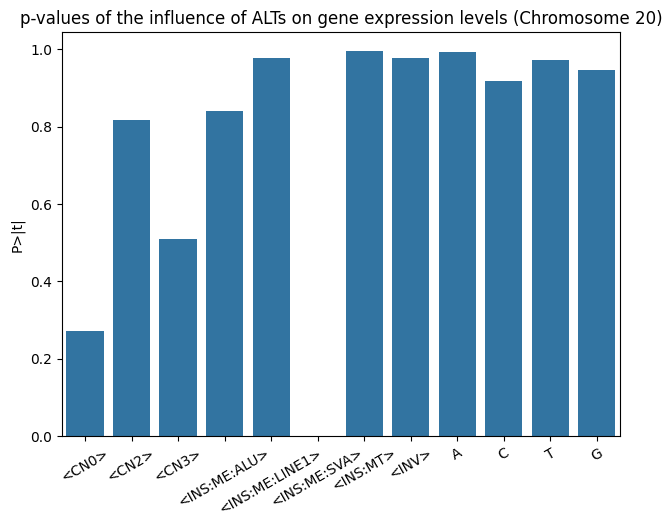

In [43]:
plt.title("p-values of the influence of ALTs on gene expression levels (Chromosome 20)")
sns.barplot(pValuesMean)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

In [44]:
len(p_values)

445

In [45]:
p_values
df = pd.DataFrame(p_values)

In [46]:
df.mean()

HG00096    0.746328
HG00097    0.756219
HG00099    0.779400
HG00100    0.769543
HG00101    0.761933
             ...   
NA20814    0.814994
NA20815    0.803355
NA20819    0.745504
NA20826    0.782771
NA20828    0.790788
Length: 445, dtype: float64

In [47]:
df.mean().mean()

0.7643071966863302

In [48]:
vcfRnaMerged.to_csv("mergedData.csv")

In [49]:
df.to_csv("p_values.csv")